# EDA using covid data from Our World in Data covid-19 datsets


### Disclaimer:
> This is not a scientific analyses, neither a rigorous work. This notebook has the sole purpose of showing up some techniques and analyses that one could make using COVID-19 public datasets and python packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import CovidUtils as cv
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [2]:
df = cv.get_full_DataSet()

In [3]:
df.iso_code.unique()[:15]

array(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG',
       'ARM', 'ABW', 'OWID_ASI', 'AUS', 'AUT', 'AZE'], dtype=object)

In [4]:
# This function calculates average time between first and second dose
def get_time_to_reach(code, target=60.0):
    dd = df[df.iso_code==code][['date',
                                 'people_vaccinated_per_hundred',
                                 'people_fully_vaccinated_per_hundred']].dropna().copy()

    dd = dd[dd.people_vaccinated_per_hundred<=target].copy()

    first_dose_vals = dd.people_vaccinated_per_hundred.values

    time_delta = np.array([])

    for val in first_dose_vals:
        endval = dd[dd.people_fully_vaccinated_per_hundred>=val]['people_fully_vaccinated_per_hundred'].min()

        if not pd.isna(endval):
            start = dd[dd.people_vaccinated_per_hundred>=val]['date'].min()
            end = dd[dd.people_fully_vaccinated_per_hundred>=val]['date'].min()

            time_delta = np.append(time_delta,(end-start).days)
            
    return round(time_delta.mean(),0)

## Countries vaccination rank (over 50M population)

In [5]:
import math

millnames = ['',' Thousand',' Million',' Billion',' Trillion']

# Format numbers in thousands, millions, billions etc
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])


people = 5e7
rank = df[(df.population>people)&
          (~df.iso_code.str.contains('OWID'))].groupby('location')['people_vaccinated_per_hundred'
                                                                  ].max().sort_values(ascending=False).head(20)

people = millify(people)

print(f'People vaccinated per hundred \nCountries with more than {people} people\n\n{rank}')

People vaccinated per hundred 
Countries with more than 50 Million people

location
China             87.24
South Korea       86.32
Italy             80.20
Japan             79.65
Vietnam           78.80
France            78.25
Brazil            77.67
United Kingdom    75.90
Colombia          74.79
Germany           73.55
United States     73.35
Thailand          72.96
Iran              69.97
Turkey            66.95
Mexico            62.89
India             60.83
Indonesia         60.03
Bangladesh        52.64
Russia            50.68
Philippines       50.53
Name: people_vaccinated_per_hundred, dtype: float64


## Countries vaccination rank (between 10M - 20M population)

In [6]:
minpeople = 1e7
maxpeople = 2e7
rank = df[(df.population>minpeople)&(df.population<maxpeople)&
          (~df.iso_code.str.contains('OWID'))].groupby('location')['people_vaccinated_per_hundred'
                                                                  ].max().sort_values(ascending=False).head(20)

minpeople = millify(minpeople)
maxpeople = millify(maxpeople)

print(f'People vaccinated per hundred \nCountries with population between {minpeople} and {maxpeople}\n\n{rank}')

People vaccinated per hundred 
Countries with population between 10 Million and 20 Million

location
Cuba                  92.33
Portugal              90.28
Chile                 90.00
Cambodia              84.16
Ecuador               79.20
Netherlands           77.49
Belgium               76.59
Sweden                76.31
Greece                72.14
Czechia               63.60
Dominican Republic    63.35
Tunisia               57.90
Rwanda                57.33
Azerbaijan            50.56
Honduras              48.85
Bolivia               47.44
Kazakhstan            47.36
Jordan                42.18
Romania               41.46
Guatemala             35.81
Name: people_vaccinated_per_hundred, dtype: float64


## General overview of countries: cases, deaths and fully vaccionation rates normalized 

Selecting some intreresting countries to visualize

<ipython-input-7-7853e86cbd9c>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40);


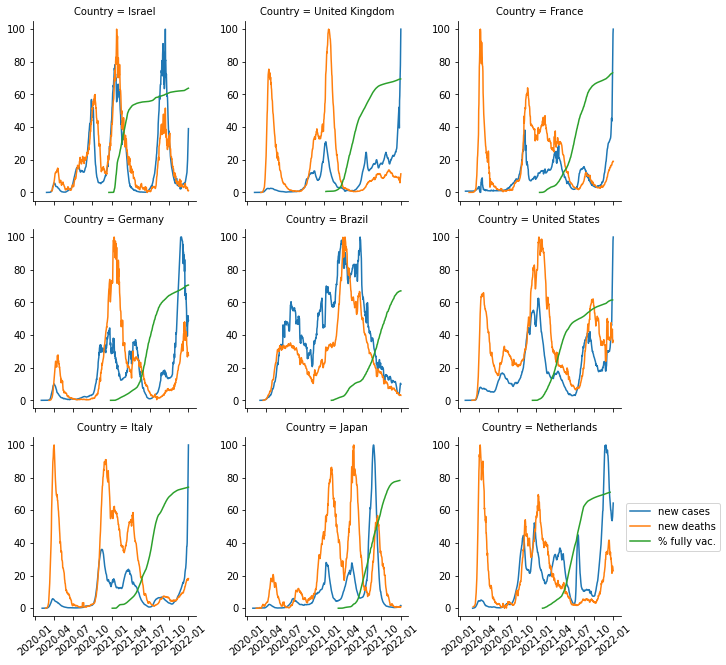

In [7]:
code = ['ISR','GBR', 'FRA', 'DEU', 'BRA', 'USA', 'ITA', 'JPN', 'NLD']

aux = pd.DataFrame()

for country in code:

    name = df[df.iso_code==country].iloc[0]['location']

    dd = cv.get_country(df, 
                      cols=['date','new_cases_smoothed','new_deaths_smoothed',
                            'people_fully_vaccinated_per_hundred',
#                             'people_vaccinated_per_hundred'
                           ],
                      code=[country])


    dd.new_cases_smoothed = 100*(dd.new_cases_smoothed - dd.new_cases_smoothed.min())/ \
                                (dd.new_cases_smoothed.max() - dd.new_cases_smoothed.min())

    dd.new_deaths_smoothed = 100*(dd.new_deaths_smoothed - dd.new_deaths_smoothed.min())/ \
                                (dd.new_deaths_smoothed.max() - dd.new_deaths_smoothed.min())
    
    dd['Country'] = name
    
    aux = pd.concat([aux,dd],axis=0)
    
    labels_dict = {'new_cases_smoothed':'new cases',
                   'new_deaths_smoothed':'new deaths',
                   'people_fully_vaccinated_per_hundred':'% fully vac.',
                   'people_vaccinated_per_hundred':'% at least 1 dose'}
    
aux = aux.melt(id_vars=['date','Country'])
aux.variable = aux.variable.map(labels_dict)
    
g = sns.FacetGrid(aux, col="Country", hue='variable', col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y='value')

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40);

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## The countries have different vaccination pacing

Israel and Japan are faster with shorter interval between dose, while Brazil and UK opted by a bigger spacing between jabs

<ipython-input-8-83c862c577d4>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40);


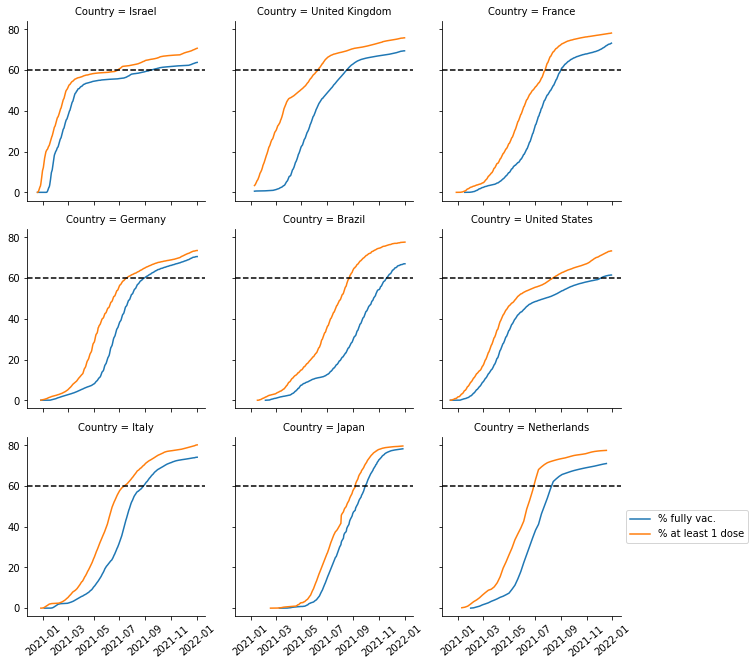

In [8]:
target = 60
aux = pd.DataFrame()

for country in code:

    name = df[df.iso_code==country].iloc[0]['location']

    dd = cv.get_country(df, 
                      cols=['date',
                            'people_fully_vaccinated_per_hundred',
                            'people_vaccinated_per_hundred'
                           ],
                      code=[country])

    dd['Country'] = name
    
    aux = pd.concat([aux,dd],axis=0)
    
    labels_dict = {'new_cases_smoothed':'new cases',
                   'new_deaths_smoothed':'new deaths',
                   'people_fully_vaccinated_per_hundred':'% fully vac.',
                   'people_vaccinated_per_hundred':'% at least 1 dose'}
    
aux = aux.melt(id_vars=['date','Country'])
aux.variable = aux.variable.map(labels_dict)
    
g = sns.FacetGrid(aux, col="Country", hue='variable', col_wrap=3, sharey=True,sharex=True)
g.map_dataframe(sns.lineplot, x="date", y='value')

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40);
    ax.axhline(y=target, color='k', linestyle='--')

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [9]:
print('Average time between doses \nbefore {}% of people vaccinated\n'.format(target))
for country in code:
    print(country, get_time_to_reach(country,target))

Average time between doses 
before 60% of people vaccinated

ISR 29.0
GBR 75.0
FRA 41.0
DEU 37.0
BRA 56.0
USA 32.0
ITA 34.0
JPN 24.0
NLD 49.0


## How are daily new deaths behaving with vaccination progress

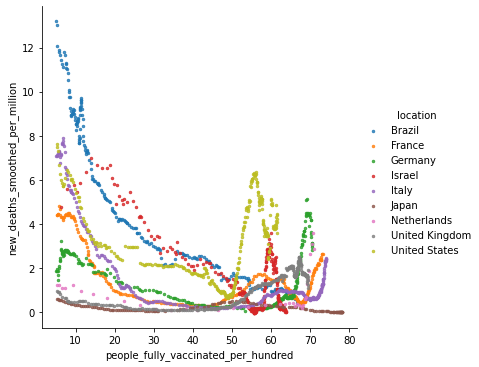

In [10]:
code = ['ISR','GBR', 'FRA', 'DEU', 'BRA', 'USA', 'ITA', 'JPN', 'NLD']

aux = df[(df.population>8e6)&(df.people_vaccinated_per_hundred>10)&(~df.location.isin(['World','China']))&
         (df.human_development_index>0.75)&
         (df.iso_code.isin(code))&
         (df.people_fully_vaccinated_per_hundred>5)&(df.life_expectancy>70)].copy()

sns.lmplot(x='people_fully_vaccinated_per_hundred',y='new_deaths_smoothed_per_million',
           data=aux, 
           hue='location',
           logx=True,
           scatter=True,
           fit_reg=False,
           scatter_kws={'s':6}
          )

## How is death rate behaving with vaccination progress

In [11]:
# np.quantile(aux.death_rate.values,0.95)

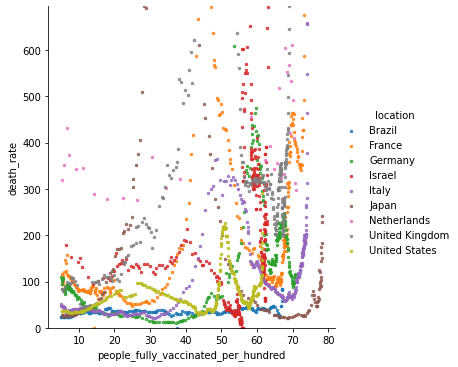

In [12]:
aux['death_rate'] = aux.new_cases_smoothed/aux.new_deaths_smoothed
aux['death_rate'] = np.where(aux.death_rate.isin([np.nan,np.inf]),0,aux.death_rate)

ax = sns.lmplot(x='people_fully_vaccinated_per_hundred',y='death_rate',
           data=aux, 
           hue='location',
           logx=True,
           scatter=True,
           fit_reg=False,
           scatter_kws={'s':6}
          )

ax.set(ylim=(0,np.quantile(aux.death_rate.values,0.95)))

## Top 20 vaccinated European countries overview

In [13]:
code=df[(df.population>5e6)&(df.continent=='Europe')&(~df.iso_code.str.contains('OWID'))
    ].groupby('iso_code')['people_vaccinated_per_hundred'].max().sort_values(ascending=False).head(20).index.to_list()

<ipython-input-14-0dc2d746557a>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40);


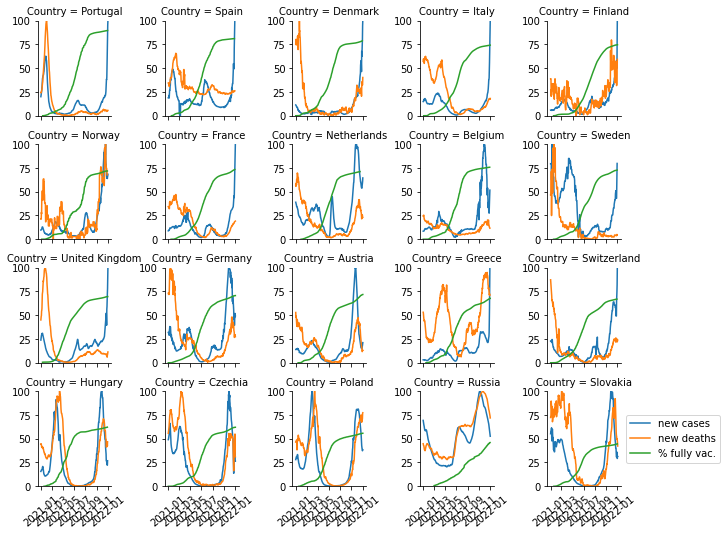

In [14]:
aux = pd.DataFrame()

for country in code:

    name = df[df.iso_code==country].iloc[0]['location']

    dd = cv.get_country(df, 
                      cols=['date','new_cases_smoothed','new_deaths_smoothed',
                            'people_fully_vaccinated_per_hundred',
#                             'people_vaccinated_per_hundred'
                           ],
                      code=[country])


    dd.new_cases_smoothed = 100*(dd.new_cases_smoothed - dd.new_cases_smoothed.min())/ \
                                (dd.new_cases_smoothed.max() - dd.new_cases_smoothed.min())

    dd.new_deaths_smoothed = 100*(dd.new_deaths_smoothed - dd.new_deaths_smoothed.min())/ \
                                (dd.new_deaths_smoothed.max() - dd.new_deaths_smoothed.min())
    
    dd['Country'] = name
    
    aux = pd.concat([aux,dd],axis=0)
    
    labels_dict = {'new_cases_smoothed':'new cases',
                   'new_deaths_smoothed':'new deaths',
                   'people_fully_vaccinated_per_hundred':'% fully vac.',
                   'people_vaccinated_per_hundred':'% at least 1 dose'}
    
aux = aux.melt(id_vars=['date','Country'])
aux.variable = aux.variable.map(labels_dict)
    
g = sns.FacetGrid(aux[aux.date>=pd.to_datetime('2021-01-01')], 
                  col="Country", hue='variable', col_wrap=5, sharey=False, height=1.8)

g.map_dataframe(sns.lineplot, x="date", y='value')

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40);
    ax.set_ylim(0,100)

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
